In [210]:
import snntorch as snn
import torch

In [211]:
batch_size = 128
data_path='data'
num_classes = 10#MNSIT has 10 classes
#Torch valiables
dtype = torch.float

In [212]:
from torchvision import datasets, transforms

transform=transforms.Compose([
        transforms.Resize((28,28)),
        transforms.Grayscale(),
        transforms.ToTensor(),
        transforms.Normalize((0,), (1))
        ])

train_dataset = datasets.MNIST(root=data_path, train=True, transform=transform, download=True)

- 大きいデータセットはSNNには不要なので、subsetで分けた分だけのデータを使う

In [213]:
from snntorch import utils

subset=10
mnist_train=utils.data_subset(train_dataset, subset)
print(f'The size of the subset is {len(mnist_train)}')

The size of the subset is 6000


In [214]:
from torch.utils.data import DataLoader
train_loader=DataLoader(mnist_train, batch_size=batch_size, shuffle=True)

### SNNをMNISTに対して適応する

- MNISTは時間で変化しないデータなので時変データに変換するためのメソッドは２種類ある

1. 同じデータを時間に対して何回も使う
1. num_stepのスパイク列にMNISTデータを変換する


<img src="https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial1/1_2_1_static.png?raw=true" width="50%"><br>

MNISTデータの変換は３種類ある
1. レート・コーディング(snntorch.spikegen.rate) : スパイクの周波数を決定するために入力を使用
1. レイテンシ符号化(snn.spikegen.latency) : 入力特徴を用いてスパイクのタイミングを決定
1. デルタ変調(snn.spikegen.delta) : 入力の時間的変化を利用してスパイクを生成

<img src="https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial1/1_2_2_spikeinput.png?raw=true" width="50%">

## 1.snntorch.spikegen.rateを用いた入力の変換方法

In [215]:
num_step=10

raw_vector=torch.ones(num_step)*0.5

rate_coded_vector=torch.bernoulli(raw_vector)
#torch.bernoulliは入力が確率であると仮定しているので、0.5を入力すると、0.5の確率で1を出力する。
print(f'Converted vector is {rate_coded_vector}')

print(f'The output spiking is {rate_coded_vector.sum()*100/len(rate_coded_vector):.2f}% of the time')

Converted vector is tensor([0., 1., 1., 0., 1., 0., 0., 1., 1., 0.])
The output spiking is 50.00% of the time


In [216]:
num_steps = 100

# create vector filled with 0.5
raw_vector = torch.ones(num_steps)*0.5

# pass each sample through a Bernoulli trial
rate_coded_vector = torch.bernoulli(raw_vector)
print(f"The output is spiking {rate_coded_vector.sum()*100/len(rate_coded_vector):.2f}% of the time.")

The output is spiking 48.00% of the time.


#### MNISTのデータ加工（スパイク入力にする）

- スパイクの発火頻度はピクセルの値に対応する
- MNISTのデータの黒いところを０にして、白のピクセルを１にする。

<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial1/1_2_3_spikeconv.png?raw=true' width="300%">

In [217]:
from snntorch import spikegen
# iterでtrain_loaderをイテレータにする, nextでイテレータからデータを取り出す
data=iter(train_loader)
data_it,targets_it=next(data)

spike_data=spikegen.rate(data_it, num_steps=num_steps)

spike_data.size()
#100はステップ数、128はバッチサイズ、1はチャンネル数、28は縦のピクセル数、28は横のピクセル数

torch.Size([100, 128, 1, 28, 28])

#### snntorch.spikeplotでのスパイクの可視化


In [218]:
import matplotlib.pyplot as plt
import snntorch.spikeplot as splt
from IPython.display import HTML

In [219]:
spike_data_sample=spike_data[:,0,0]
print(spike_data_sample.size())

torch.Size([100, 28, 28])


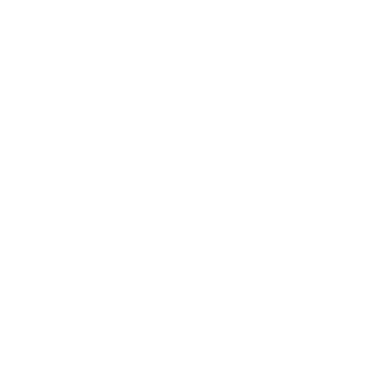

In [220]:
#MNISTの最初の画像のスパイクを表示する
fig,ax=plt.subplots()
anim1=splt.animator(spike_data_sample,fig,ax)
#plt.rcParams['animation.ffmpeg_path'] = 'C:\\path\\to\\your\\ffmpeg.exe'

anim1.save('Images/SpikeInputMNIST.gif')
HTML(anim1.to_html5_video())

- 発火頻度を下げてみる（今まではwhiteに対してすべて発火させていた

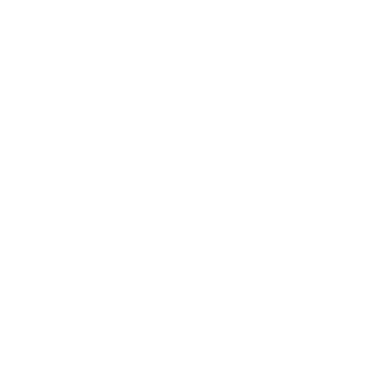

In [221]:
spike_data = spikegen.rate(data_it, num_steps=num_steps, gain=0.25)

spike_data_sample2 = spike_data[:, 0, 0]
fig, ax = plt.subplots()
anim2 = splt.animator(spike_data_sample2, fig, ax)
anim2.save('Images/SpikeInputMNISTLowfreq.gif')
HTML(anim2.to_html5_video())


In [222]:
print(f'targetに対して{targets_it[0]}が対応している')

targetに対して3が対応している


#### 入力を時間平均したもの

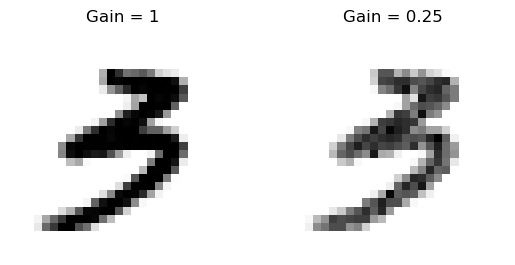

In [223]:
plt.figure(facecolor="w")
plt.subplot(1,2,1)
plt.imshow(spike_data_sample.mean(axis=0).reshape((28,-1)).cpu(), cmap='binary')
plt.axis('off')
plt.title('Gain = 1')

plt.subplot(1,2,2)
plt.imshow(spike_data_sample2.mean(axis=0).reshape((28,-1)).cpu(), cmap='binary')
plt.axis('off')
plt.title('Gain = 0.25')

plt.show()

#### 入力のパターンをラスタープロットで表示する

Text(0, 0.5, 'Neuron Number')

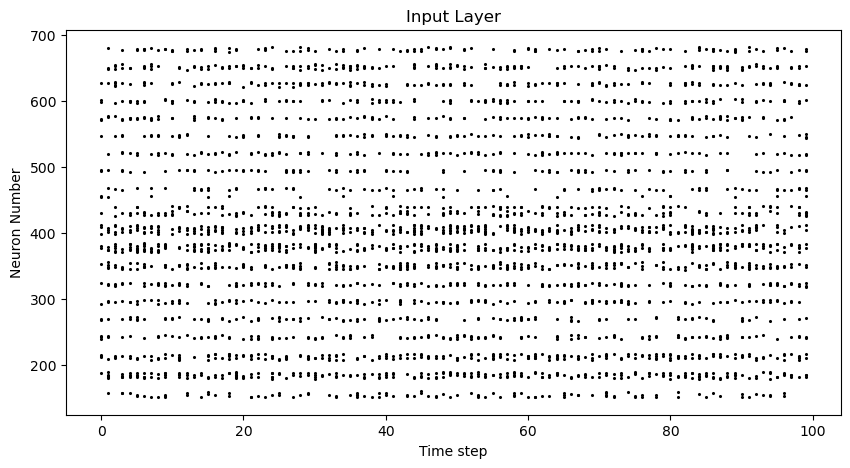

In [224]:
# Reshape
spike_data_sample2 = spike_data_sample2.reshape((num_steps, -1))

# raster plot
fig = plt.figure(facecolor="w", figsize=(10, 5))
ax = fig.add_subplot(111)
splt.raster(spike_data_sample2, ax, s=1.5, c="black")

plt.title("Input Layer")
plt.xlabel("Time step")
plt.ylabel("Neuron Number")

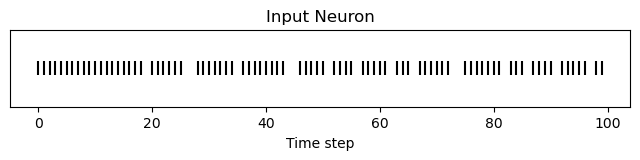

In [225]:
idx = 210  # index into 210th neuron

fig = plt.figure(facecolor="w", figsize=(8, 1))
ax = fig.add_subplot(111)

splt.raster(spike_data_sample.reshape(num_steps, -1)[:, idx].unsqueeze(1), ax, s=100, c="black", marker="|")

plt.title("Input Neuron")
plt.xlabel("Time step")
plt.yticks([])
plt.show()

## 2.snntorch.latencyを用いて入力データを変換する

- 時間によって発火頻度を変更することでノイズの影響を受けやすくなるが、マシンのリソースを減らすことができる
- spikegen.latencyは各入力が最大一回発火させる関数で1に近いほど早く発火して0に近いほど遅く発火する
- 下の図からもわかるように、微分方程式を解くことで入力が大きいと発火の時間が早くて入力が小さいと発火が遅い

<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial1/1_2_4_latencyrc.png?raw=true' width="50%">

- 上の時間の式からニューロンの発火の仕方を図示してみる

In [226]:
def convert_to_time(data, tau=5, threshold=0.01):
    spike_time = tau * torch.log(data / (data - threshold))
    return spike_time 

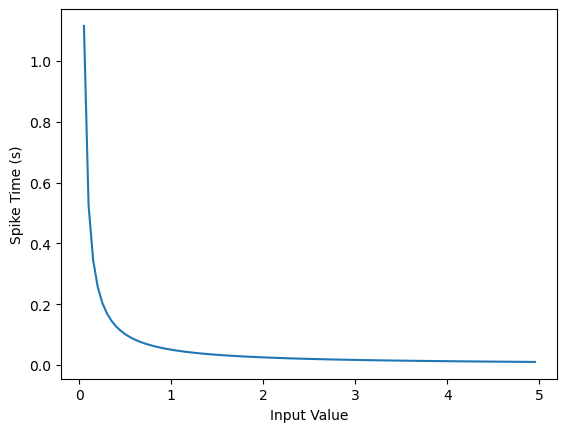

In [227]:
raw_input = torch.arange(0, 5, 0.05) # tensor from 0 to 5
spike_times = convert_to_time(raw_input)

plt.plot(raw_input, spike_times)
plt.xlabel('Input Value')
plt.ylabel('Spike Time (s)')
plt.show()

In [228]:
# spike time encodingをspiekgen.latencyで実装する
spike_data = spikegen.latency(data_it, num_steps=100, tau=5, threshold=0.01)

<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial1/1_2_5_latencyraster.png?raw=true' width="70%">

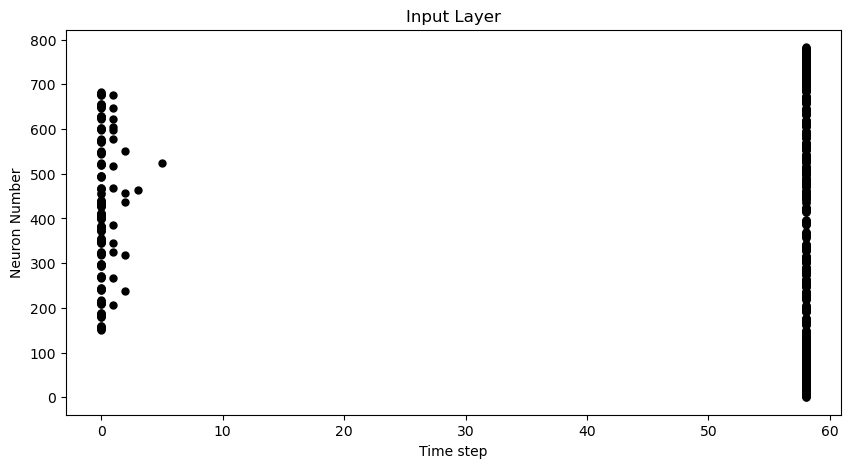

In [229]:
fig = plt.figure(facecolor="w", figsize=(10, 5))
ax = fig.add_subplot(111)
splt.raster(spike_data[:, 0].view(num_steps, -1), ax, s=25, c="black")

plt.title("Input Layer")
plt.xlabel("Time step")
plt.ylabel("Neuron Number")
plt.show()

fig.savefig('Images/SpikeTimeEncodingInput.png', format='png', dpi=300)

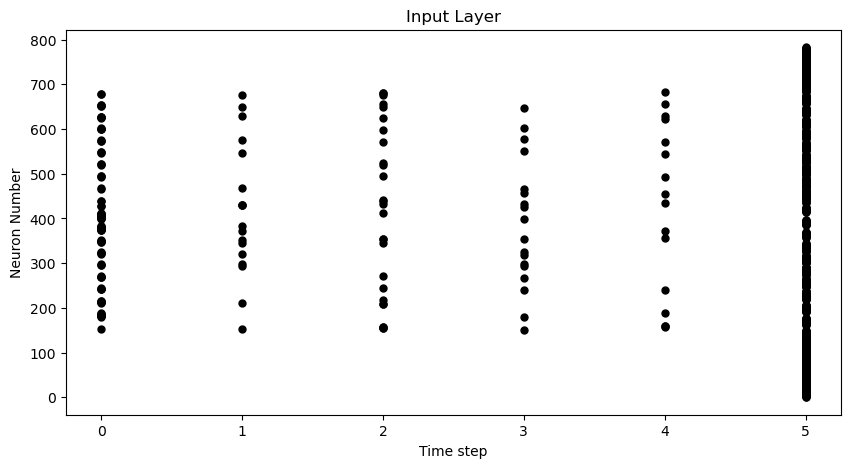

In [230]:
#linar=Trueで線形のスパイクを出力する
spike_data = spikegen.latency(data_it, num_steps=100, tau=5, threshold=0.01, linear=True)

fig = plt.figure(facecolor="w", figsize=(10, 5))
ax = fig.add_subplot(111)
splt.raster(spike_data[:, 0].view(num_steps, -1), ax, s=25, c="black")
plt.title("Input Layer")
plt.xlabel("Time step")
plt.ylabel("Neuron Number")
plt.show()

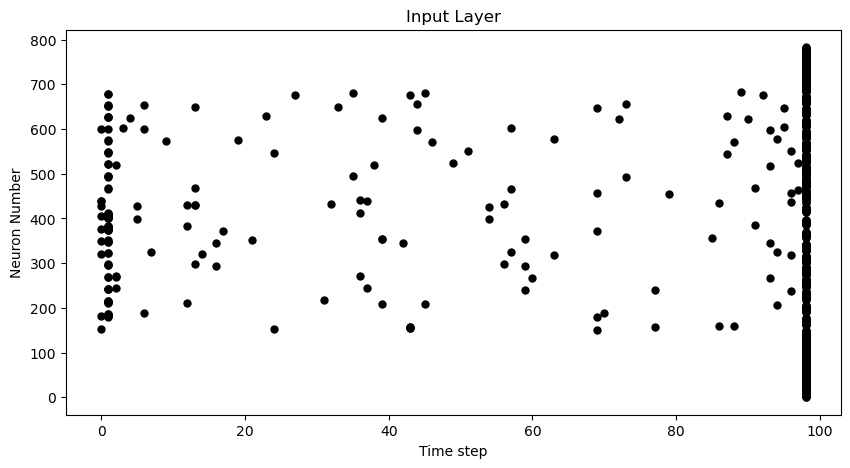

In [231]:
#Normalizerを使うとでスパイクを正規化することができる
spike_data = spikegen.latency(data_it, num_steps=100, tau=5, threshold=0.01,
                            normalize=True, linear=True)

fig = plt.figure(facecolor="w", figsize=(10, 5))
ax = fig.add_subplot(111)
splt.raster(spike_data[:, 0].view(num_steps, -1), ax, s=25, c="black")

plt.title("Input Layer")
plt.xlabel("Time step")
plt.ylabel("Neuron Number")
plt.show()

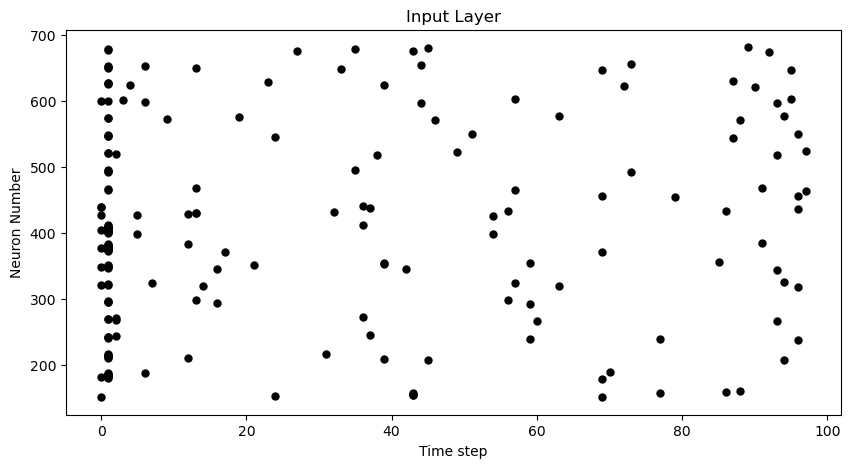

In [232]:
#clip=Trueで不要な部分（MNISTの黒い部分）を削除する
spike_data = spikegen.latency(data_it, num_steps=100, tau=5, threshold=0.01, 
                            clip=True, normalize=True, linear=True)

fig = plt.figure(facecolor="w", figsize=(10, 5))
ax = fig.add_subplot(111)
splt.raster(spike_data[:, 0].view(num_steps, -1), ax, s=25, c="black")

plt.title("Input Layer")
plt.xlabel("Time step")
plt.ylabel("Neuron Number")
plt.show()

In [233]:
spike_data_sample = spike_data[:, 0, 0]
print(spike_data_sample.size())

torch.Size([100, 28, 28])


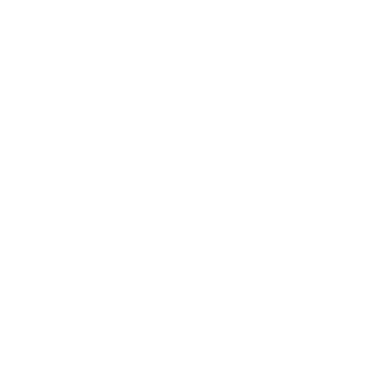

In [234]:
fig, ax = plt.subplots()
anim3 = splt.animator(spike_data_sample, fig, ax)
anim3.save('Images/SpikeInputMNISTLatency.gif')
HTML(anim3.to_html5_video())

## デルタ変調による入力の変換

- スパイクの発火は変化があれば発火しやすい。デルタ変調は変化に対応してスパイクを発火させる
- snntorch.delta関数は時系列テンソルを入力とする

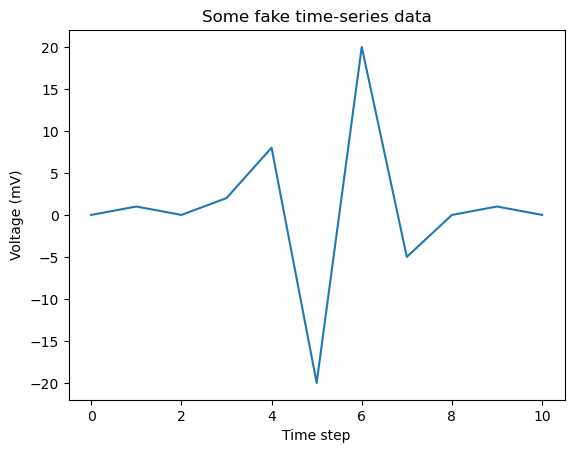

In [235]:
# Create a tensor with some fake time-series data
data = torch.Tensor([0, 1, 0, 2, 8, -20, 20, -5, 0, 1, 0])

# Plot the tensor
plt.plot(data)

plt.title("Some fake time-series data")
plt.xlabel("Time step")
plt.ylabel("Voltage (mV)")
plt.show()

(0.0, 11.0)

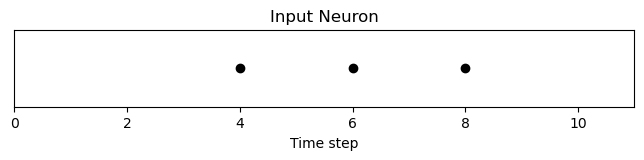

In [236]:
# Convert data
spike_data = spikegen.delta(data, threshold=4)

# Create fig, ax
fig = plt.figure(facecolor="w", figsize=(8, 1))
ax = fig.add_subplot(111)

# Raster plot of delta converted data
splt.raster(spike_data, ax, c="black")

plt.title("Input Neuron")
plt.xlabel("Time step")
plt.yticks([])
plt.xlim(0, len(data))

In [237]:
# Create a random spike train
spike_prob = torch.rand((num_steps, 28, 28), dtype=dtype) * 0.5
spike_rand = spikegen.rate_conv(spike_prob)

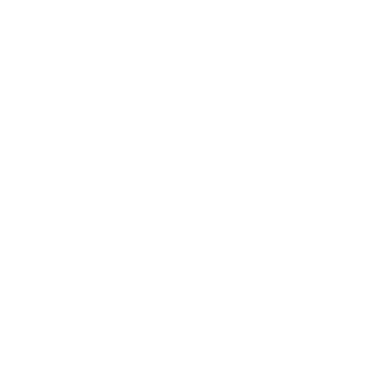

In [238]:
fig, ax = plt.subplots()
anim = splt.animator(spike_rand, fig, ax)

HTML(anim.to_html5_video())

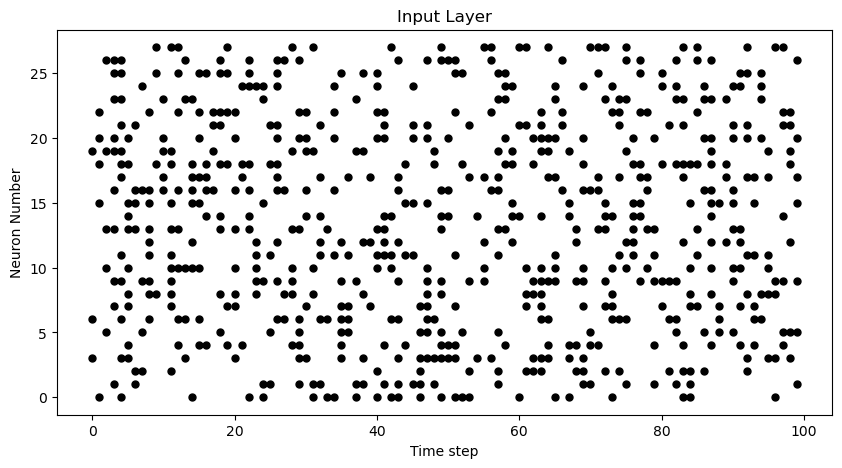

In [239]:
fig = plt.figure(facecolor="w", figsize=(10, 5))
ax = fig.add_subplot(111)
splt.raster(spike_rand[:, 0].view(num_steps, -1), ax, s=25, c="black")

plt.title("Input Layer")
plt.xlabel("Time step")
plt.ylabel("Neuron Number")
plt.show()